In [2]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner

/Users/daniele/Library/Python/3.9/lib/python/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


[ 0.46954762  1.87898004  2.01075462  2.02183974  3.91877923  6.02254716
  6.41474963  7.10360582  8.71292997  9.39405108  9.60984079  9.71012758
 10.20448107 11.03751412 11.82744259 11.8727719  12.01965612 12.89262977
 13.17978624 13.81829513 14.33532874 15.89695836 16.13095179 18.3191362
 19.65823617 20.88767561 21.03825611 24.4425592  25.32916025 26.45556121
 26.53894909 28.28069626 28.94060929 29.61401975 31.54283509 31.79831794
 31.85689525 35.95079006 36.37107709 36.87251707 38.34415188 41.42629945
 41.466194   42.36547993 43.70319538 43.75872113 43.86015135 45.61503322
 46.14793623 46.63107729 46.86512016 52.18483218 52.32480535 52.88949198
 54.4883183  54.88135039 56.66014542 56.80445611 56.84339489 57.01967704
 57.59464956 58.65129348 60.27633761 60.48455197 61.20957227 61.69339969
 61.76354971 63.99210213 64.58941131 65.31083255 65.63295895 66.67667154
 66.741038   67.06378696 68.18202991 69.24721194 69.76311959 71.51893664
 71.63272041 73.92635794 77.42336894 77.81567509 78.

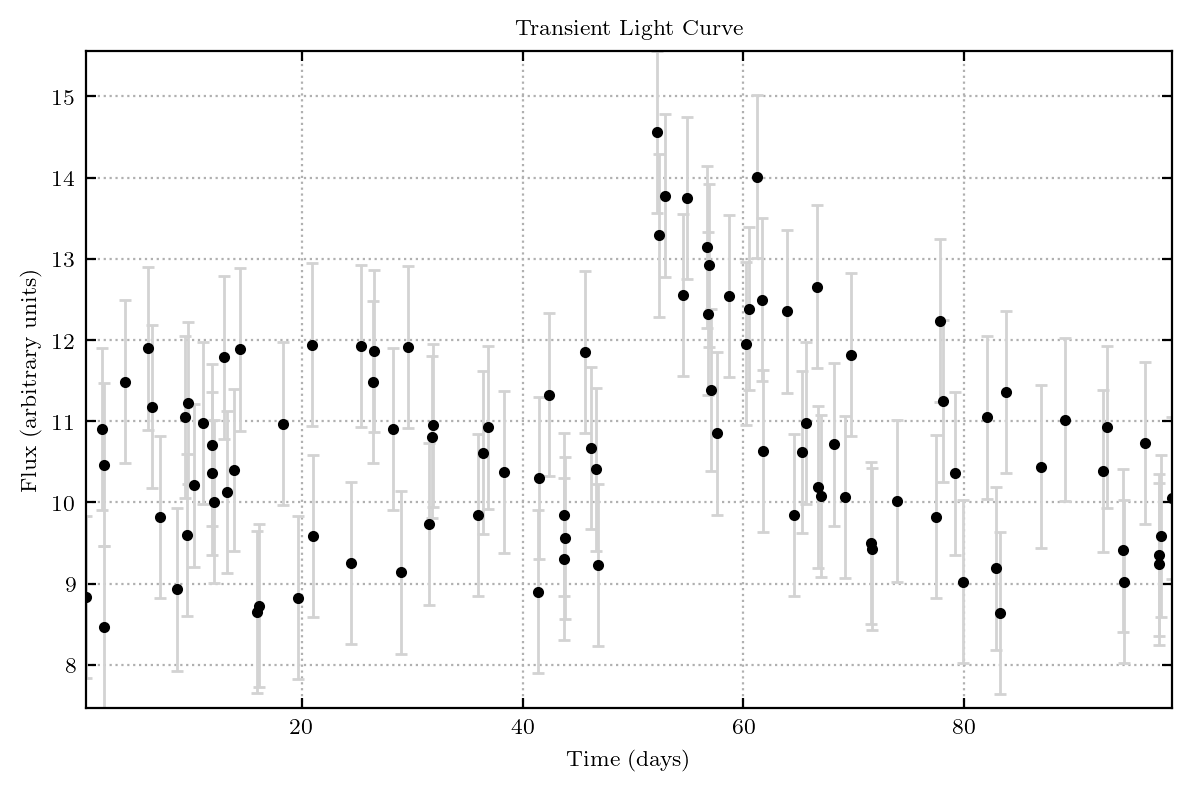

In [3]:
data=np.load('../solutions/transient.npy')
print(data[:,0])
time=data[:,0]
flux=data[:,1]
flux_err=data[:,2]
# Plot the data
plt.figure(figsize=(6, 4))
plt.errorbar(time, flux, yerr=flux_err, fmt='o', markersize=3, color='black', ecolor='lightgray', elinewidth=1, capsize=2)
plt.xlabel('Time (days)')
plt.ylabel('Flux (arbitrary units)')
plt.title('Transient Light Curve')

plt.grid()
plt.tight_layout()

In [54]:
import dynesty
ndim=4

In [61]:
def model(b, A, t0, alpha, t):
    return np.where(t > t0, b + A * np.exp(-alpha * (t - t0)), b)

Fit this model usign nested sampling and reasonable priors

In [62]:
# def ptform(u):
#     b     = 0 + (20 - 0) * u[0]
#     A     = 0 + (20 - 0) * u[1]
#     t0    = 0 + (100 - 0) * u[2]
#     alpha = 0.01 + (1 - 0.01) * u[3]
#     return [b, A, t0, alpha]

import scipy.stats
def ptform(u):
    b=scipy.stats.uniform.ppf(u[0], loc=0, scale=50)
    A=scipy.stats.uniform.ppf(u[1], loc=0, scale=50)
    t0=scipy.stats.uniform.ppf(u[2], loc=0, scale=100)
    alpha=scipy.stats.loguniform.ppf(u[3], 0.006, 148)
    return [b, A, t0, alpha]



In [63]:
def loglike(theta):
    b, A, t0, alpha = theta
    model_flux = model(b, A, t0, alpha, time)  
    logL = -0.5 * np.sum(((flux - model_flux) / flux_err)**2 + np.log(2 * np.pi * flux_err**2))
    return logL


In [64]:
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

7807it [00:40, 193.66it/s, +500 | bound: 204 | nc: 1 | ncall: 171125 | eff(%):  4.869 | loglstar:   -inf < -140.666 <    inf | logz: -155.487 +/-  0.169 | dlogz:  0.001 >  0.509]


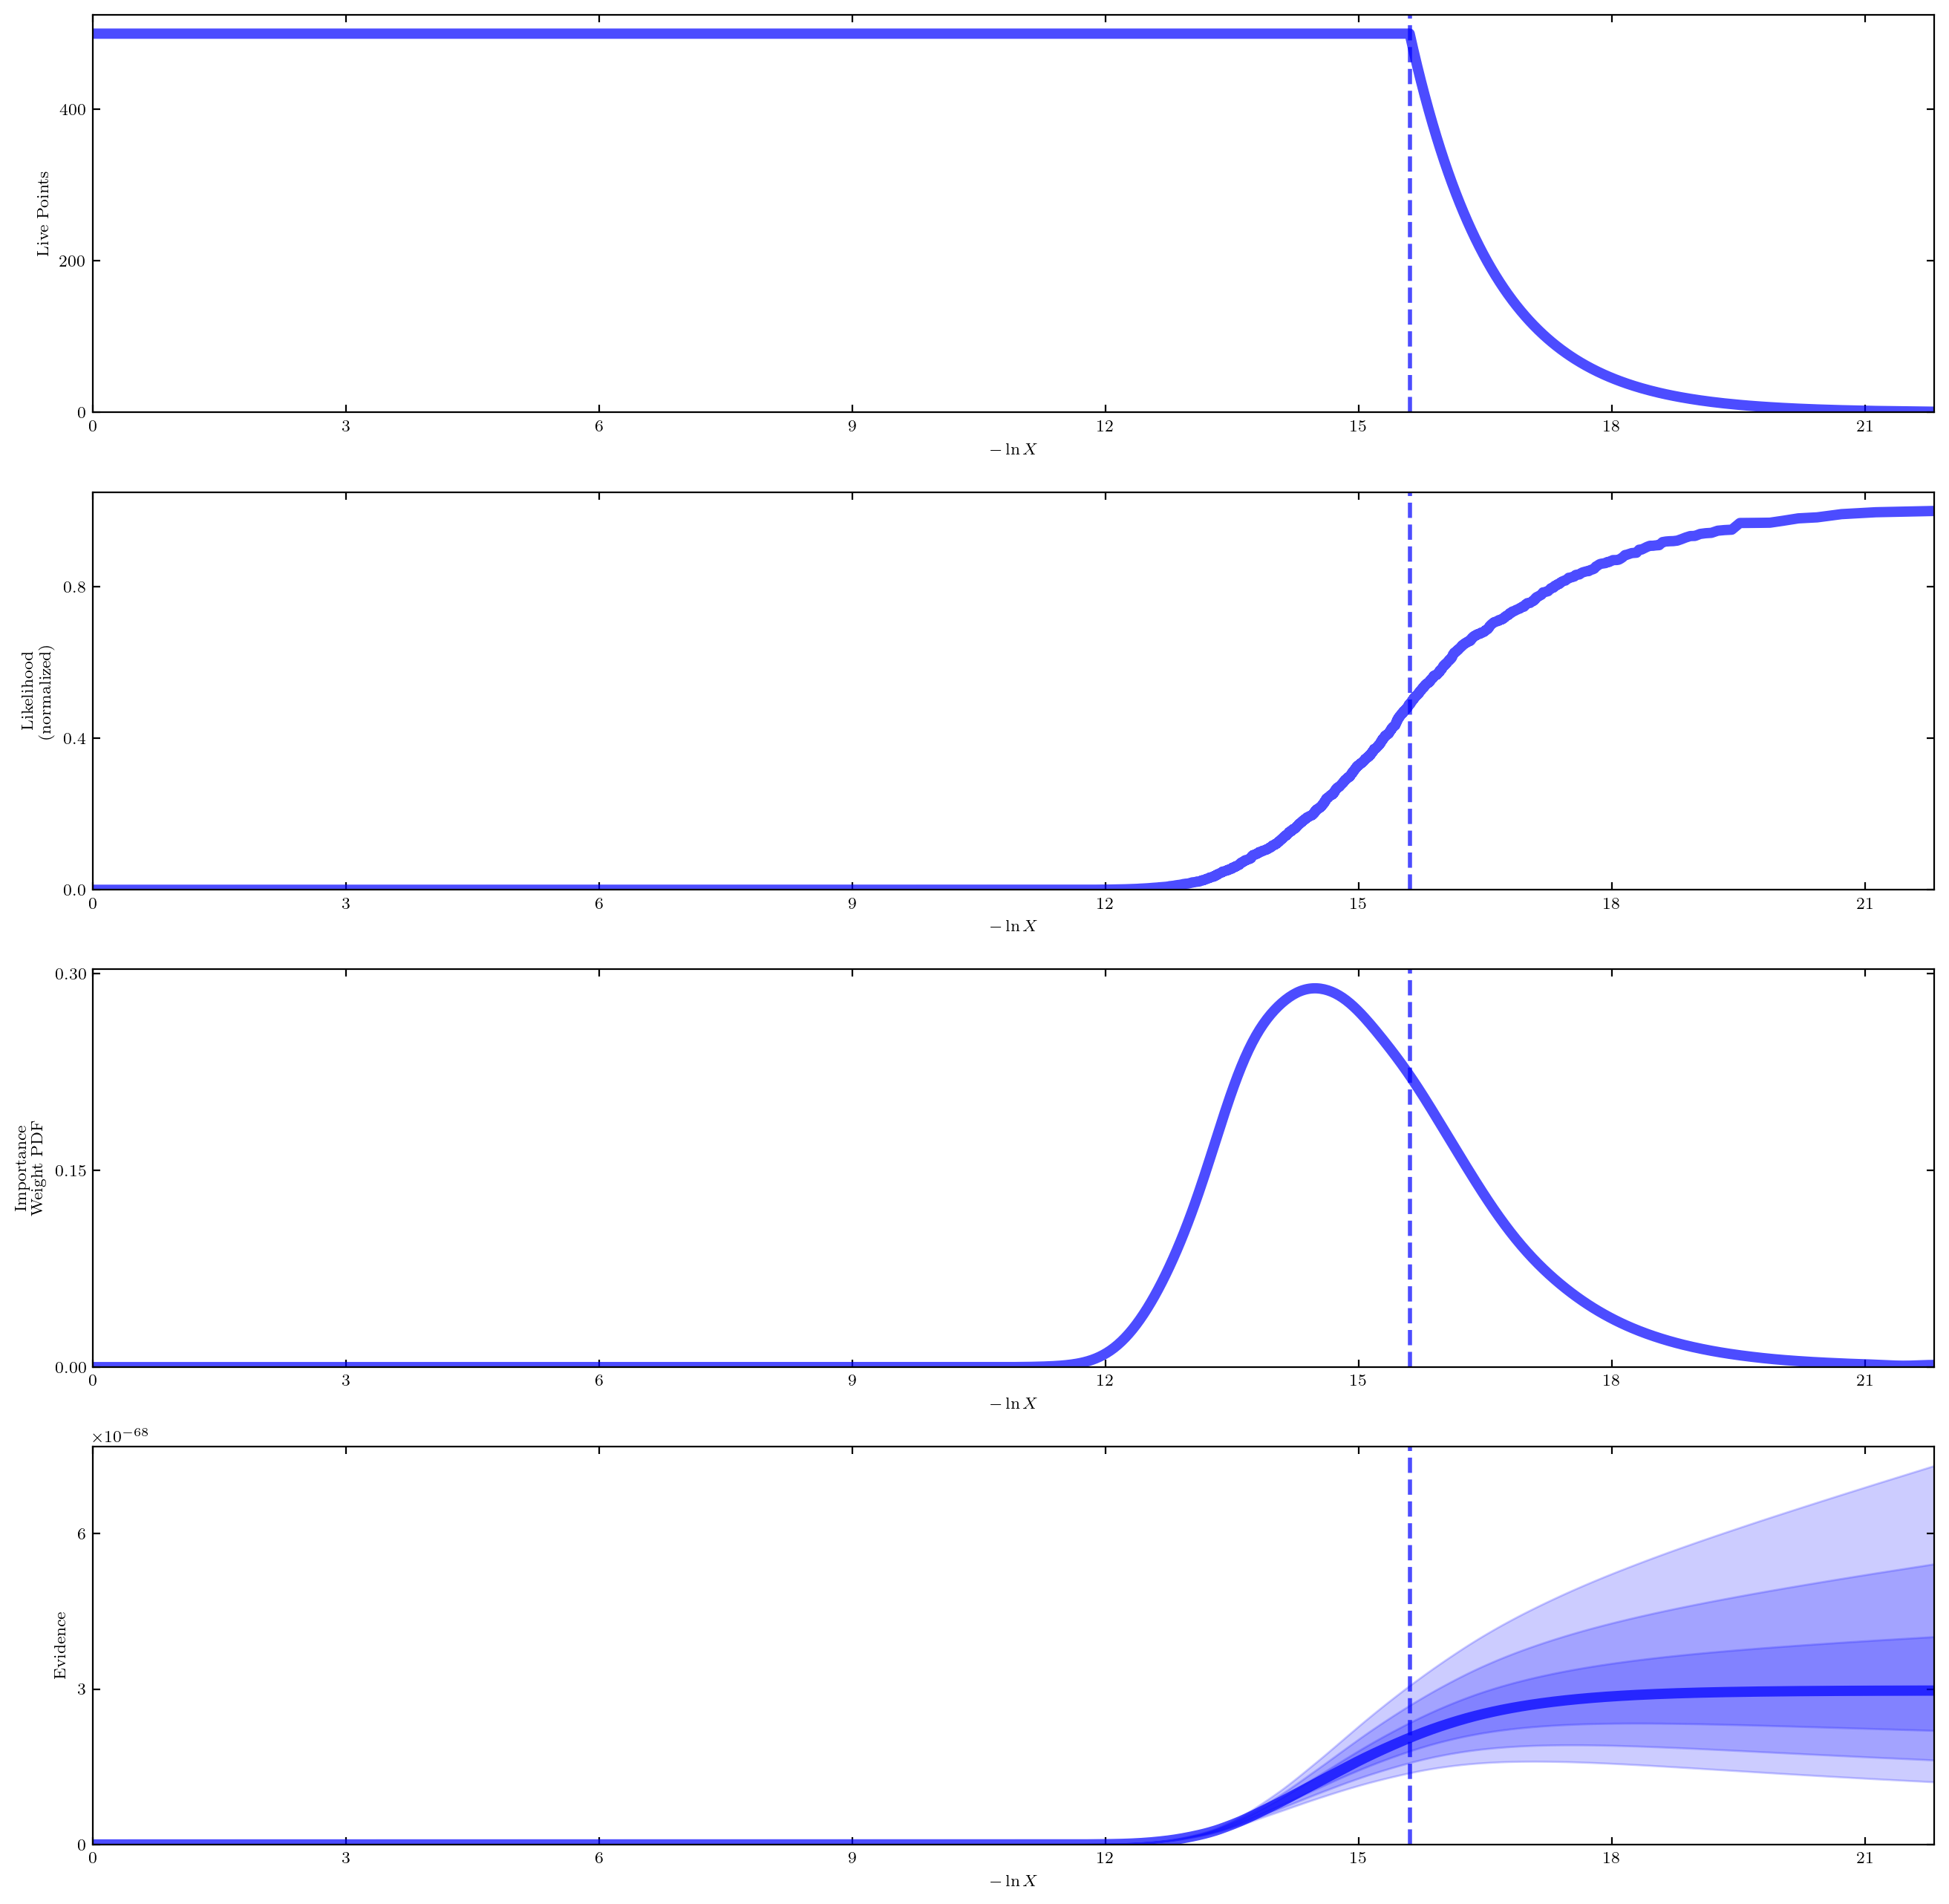

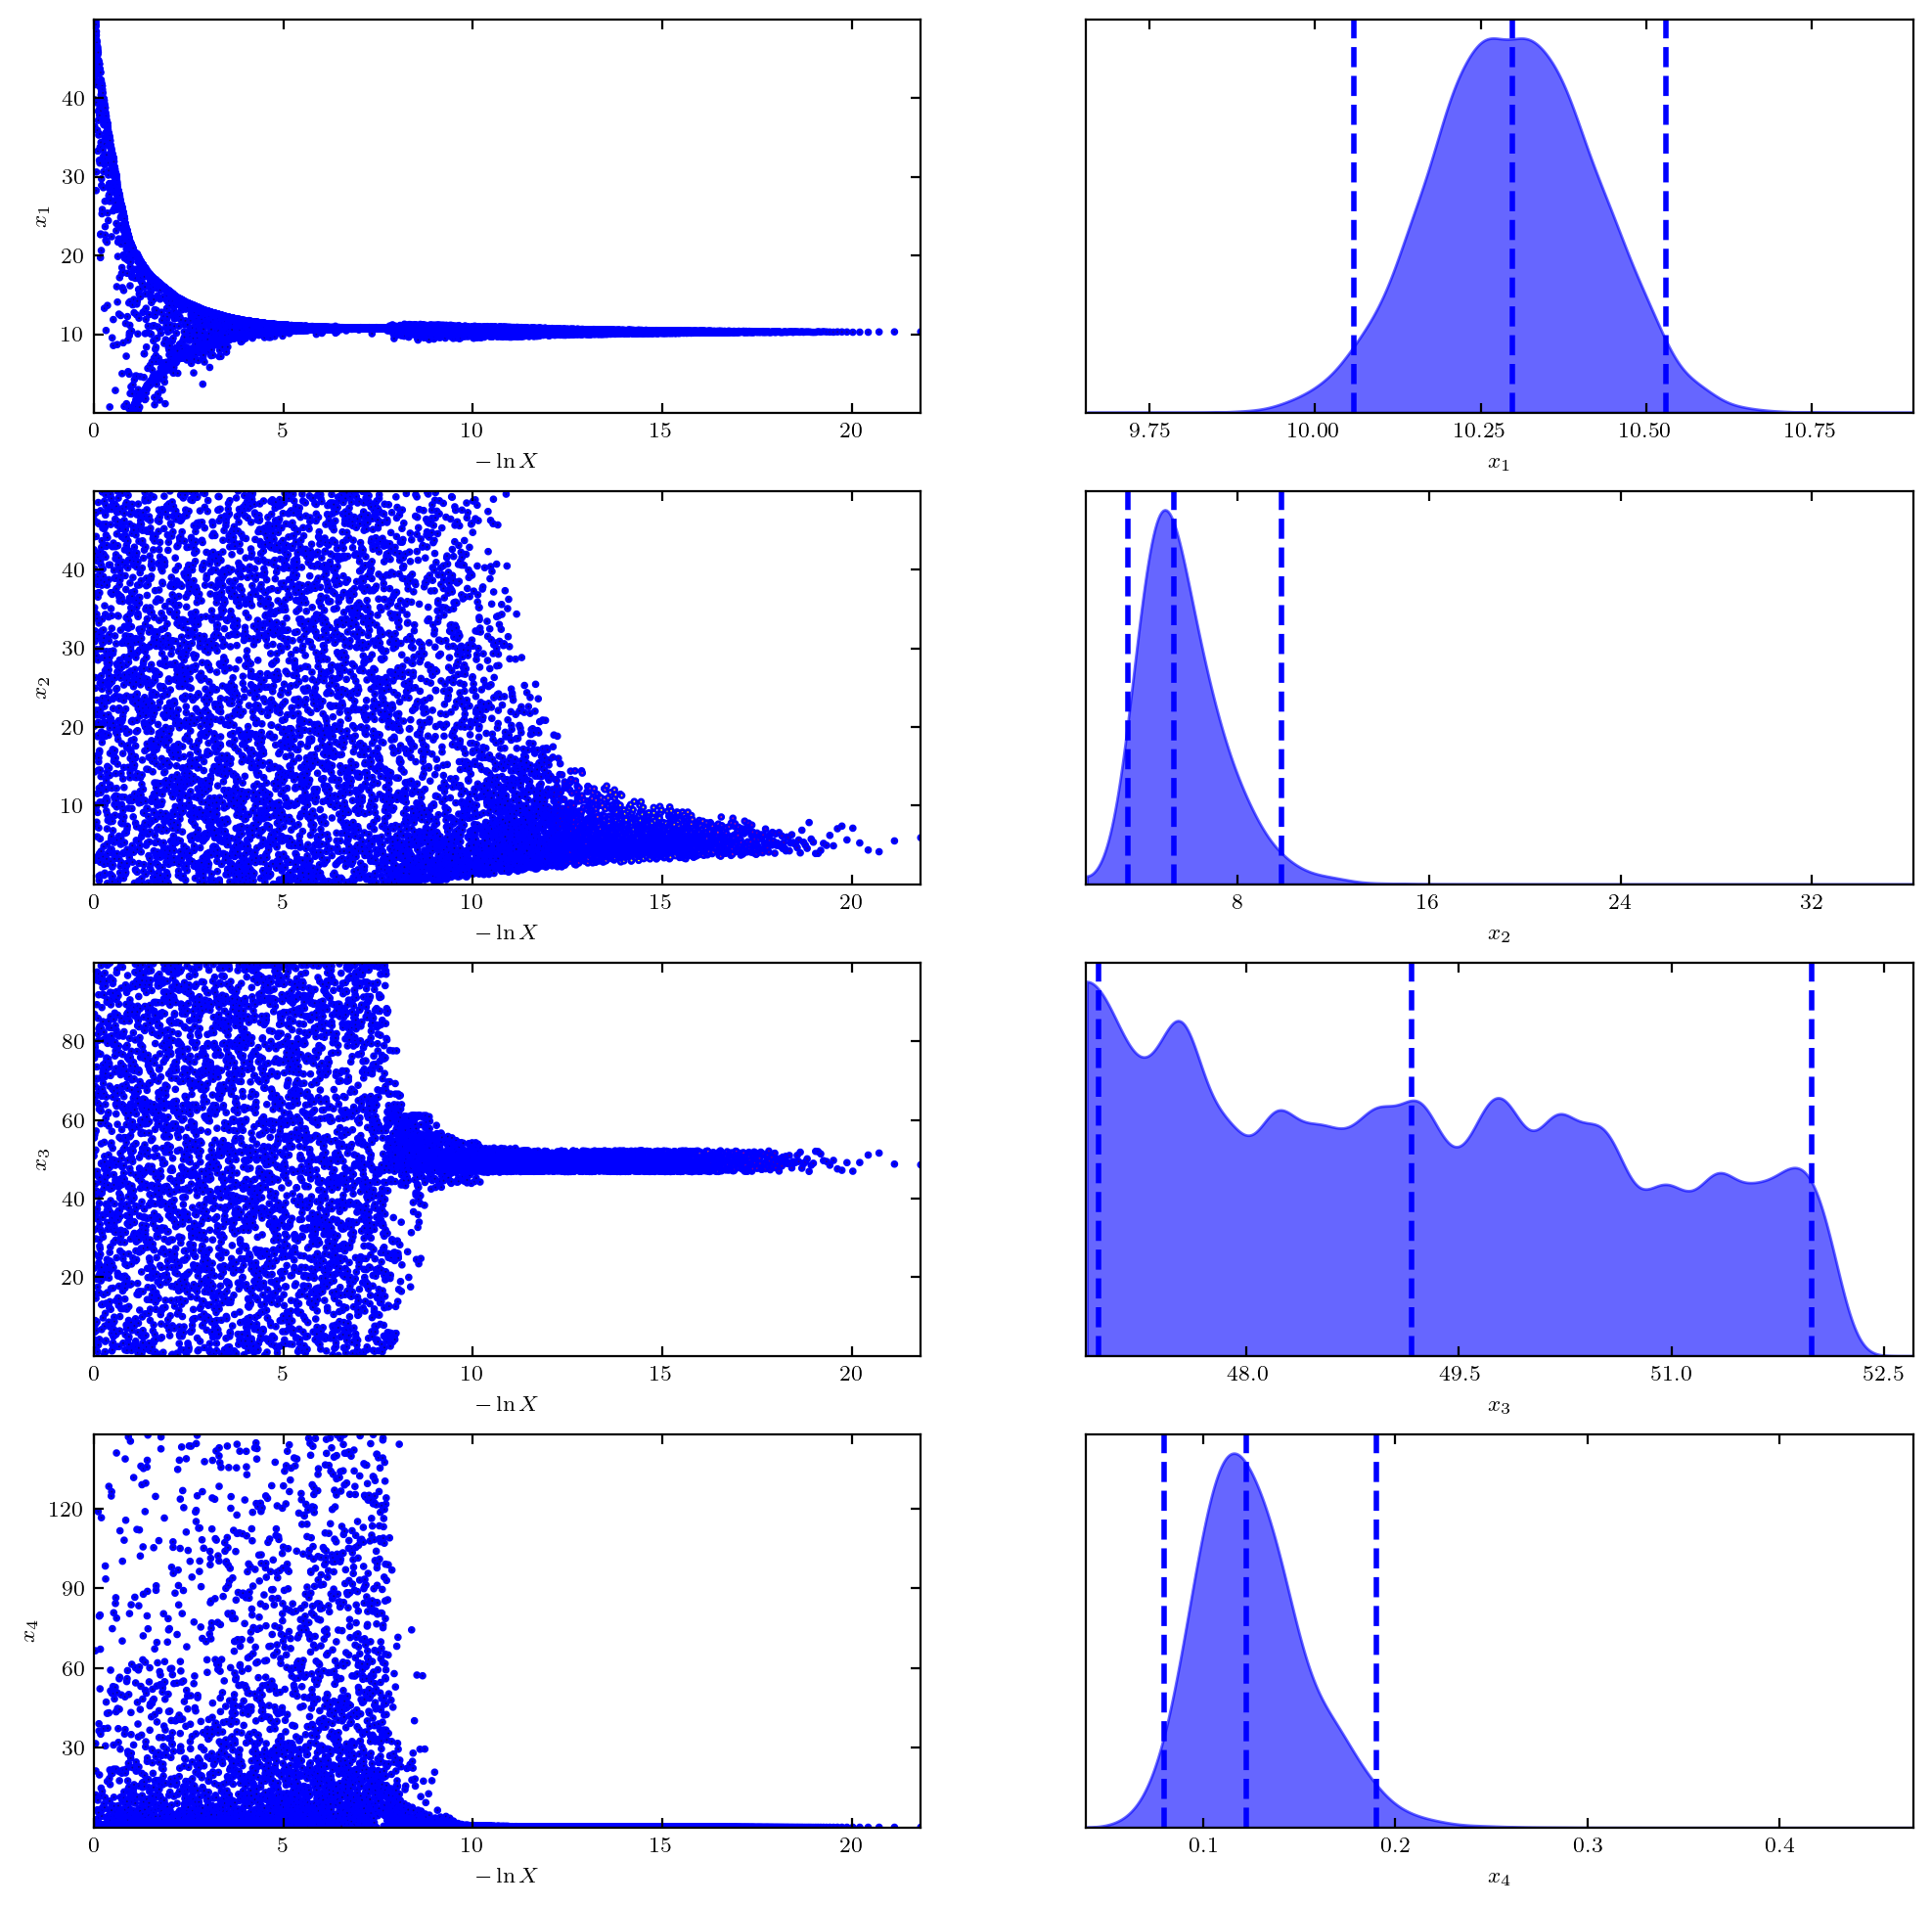

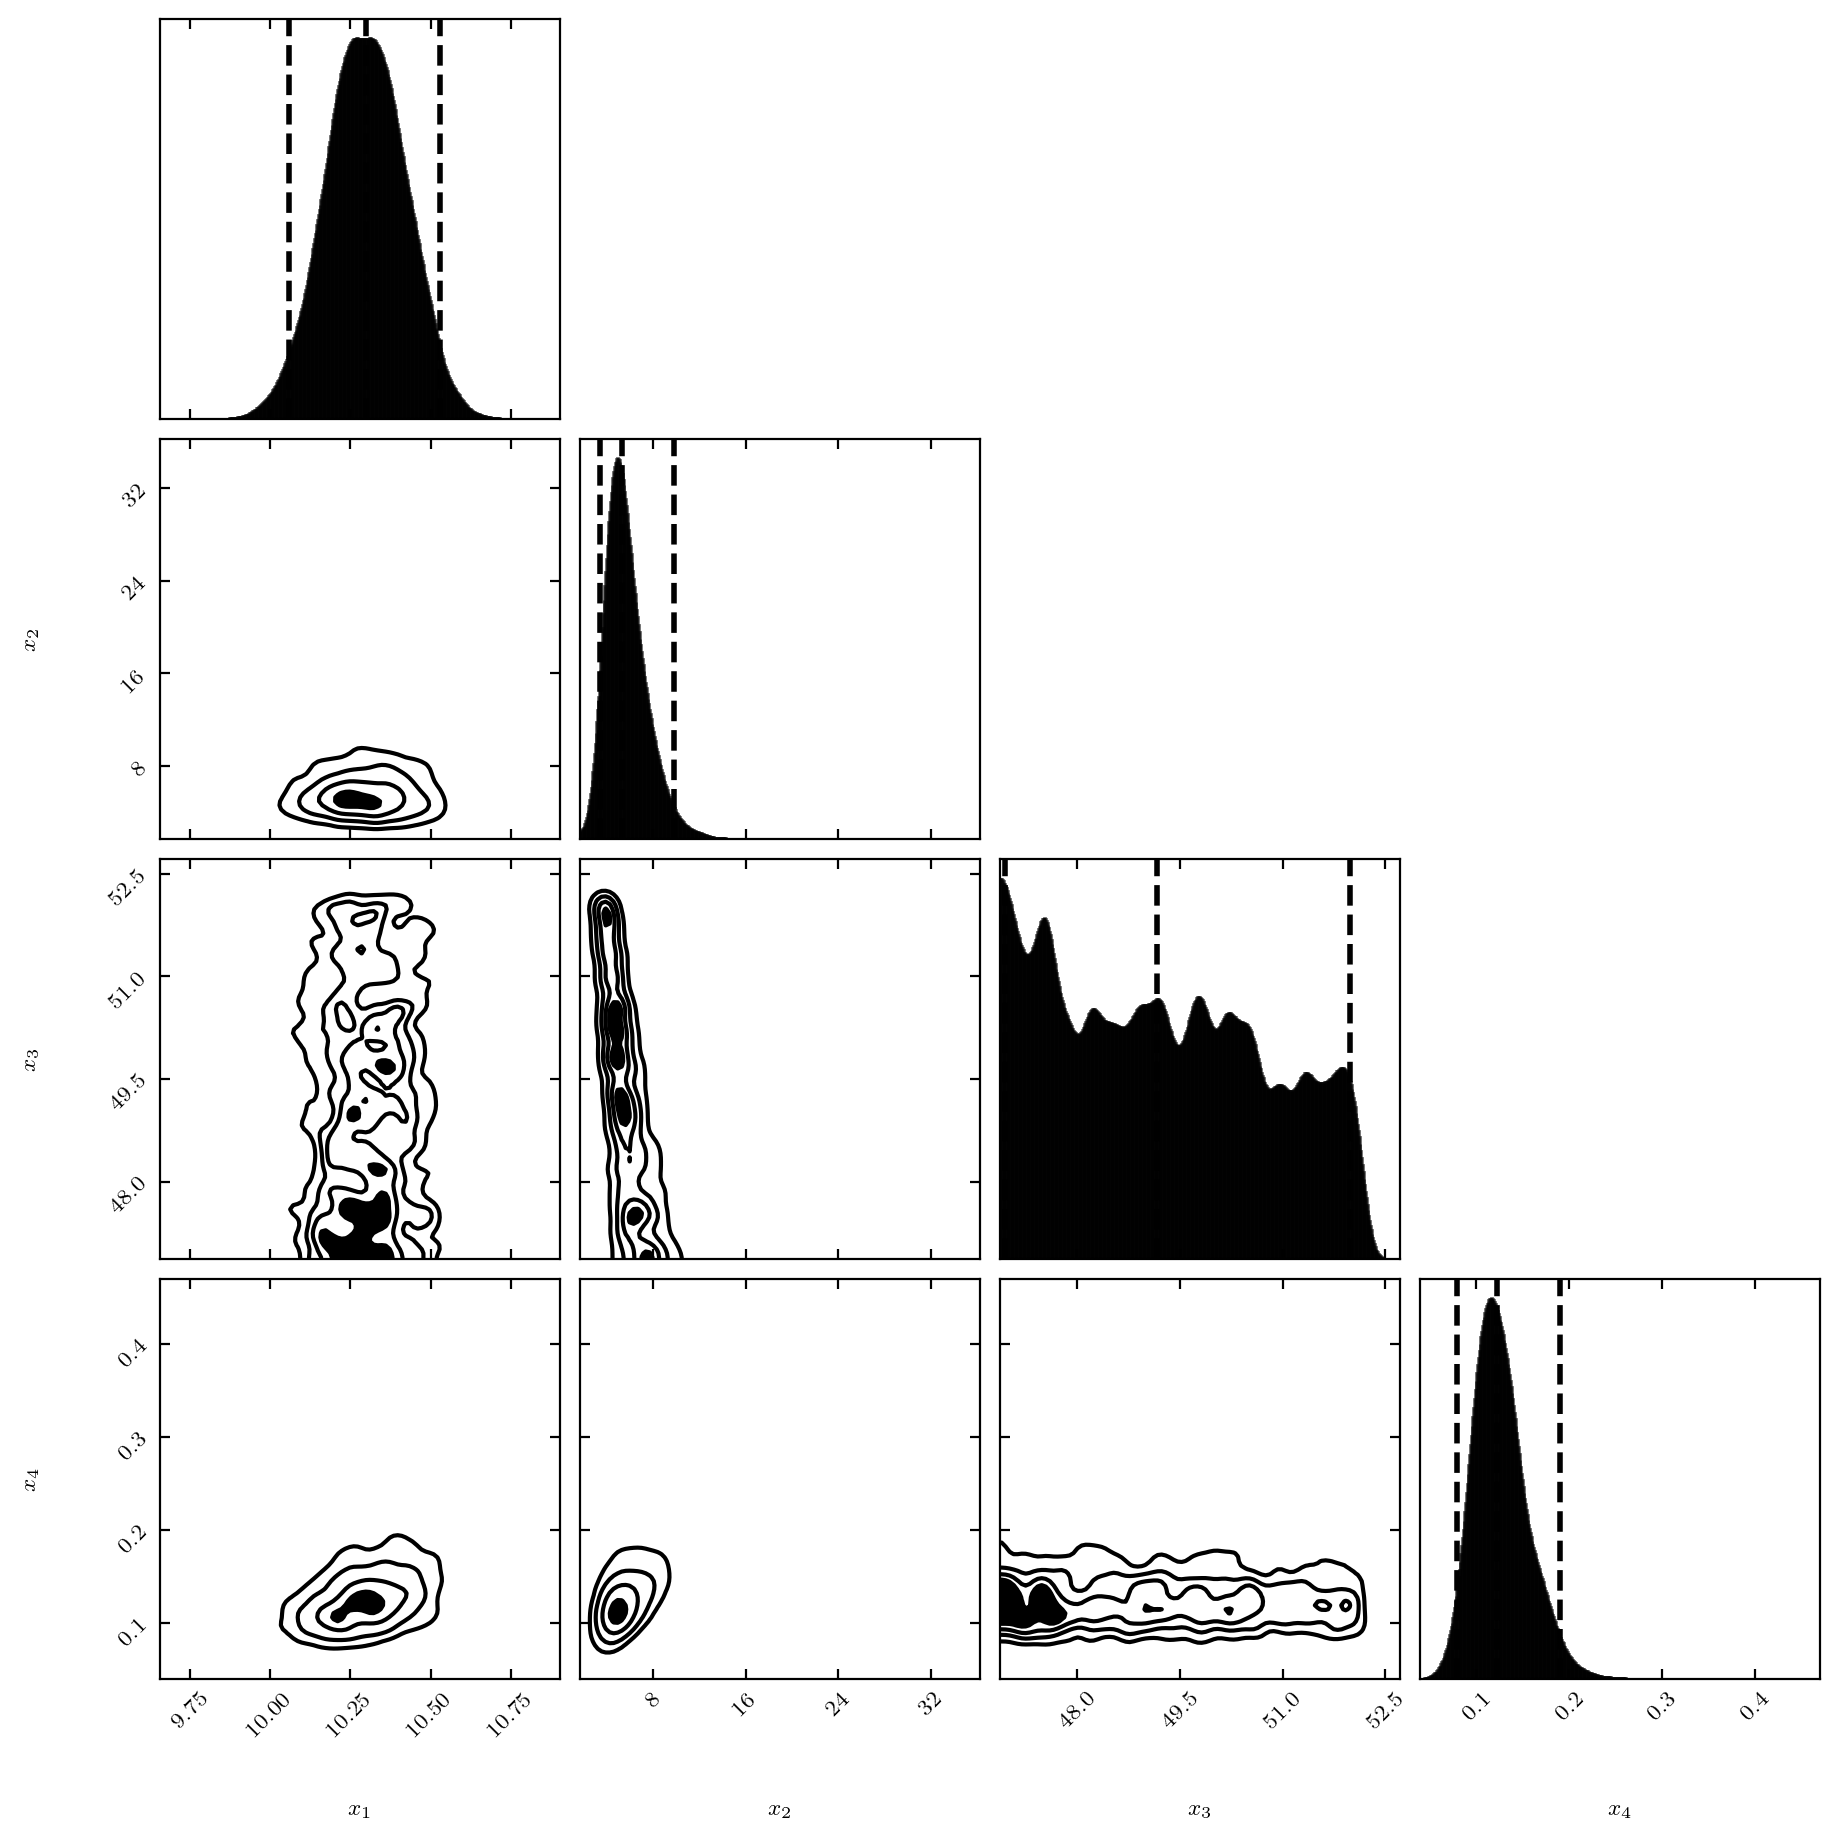

In [65]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults)
cfig, caxes = dyplot.cornerplot(sresults)

old model:

In [66]:
def model2(b, A, t0, sigmaW, t):
    return b+A*np.exp(-(t-t0)**2/(2*sigmaW**2))



In [67]:
def ptform2(u):
    b=scipy.stats.norm.ppf(u[0], loc=10, scale=4)
    A=scipy.stats.uniform.ppf(u[1], loc=0, scale=50)
    t0=scipy.stats.uniform.ppf(u[2], loc=0, scale=100)
    sigmaW=scipy.stats.loguniform.ppf(u[3], 0.1, 13)
    return [b, A, t0, sigmaW]
def loglike2(theta):
    b, A, t0, sigmaW = theta
    model_flux = model2(b, A, t0, sigmaW, time)  
    logL = -0.5 * np.sum(((flux - model_flux) / flux_err)**2 + np.log(2 * np.pi * flux_err**2))
    return logL

In [68]:
ndim=4
sampler2 = dynesty.NestedSampler(loglike2, ptform2, ndim)
sampler2.run_nested()
sresults2 = sampler2.results

7402it [00:23, 317.22it/s, +500 | bound: 112 | nc: 1 | ncall: 101236 | eff(%):  7.844 | loglstar:   -inf < -144.328 <    inf | logz: -158.393 +/-  0.167 | dlogz:  0.001 >  0.509]


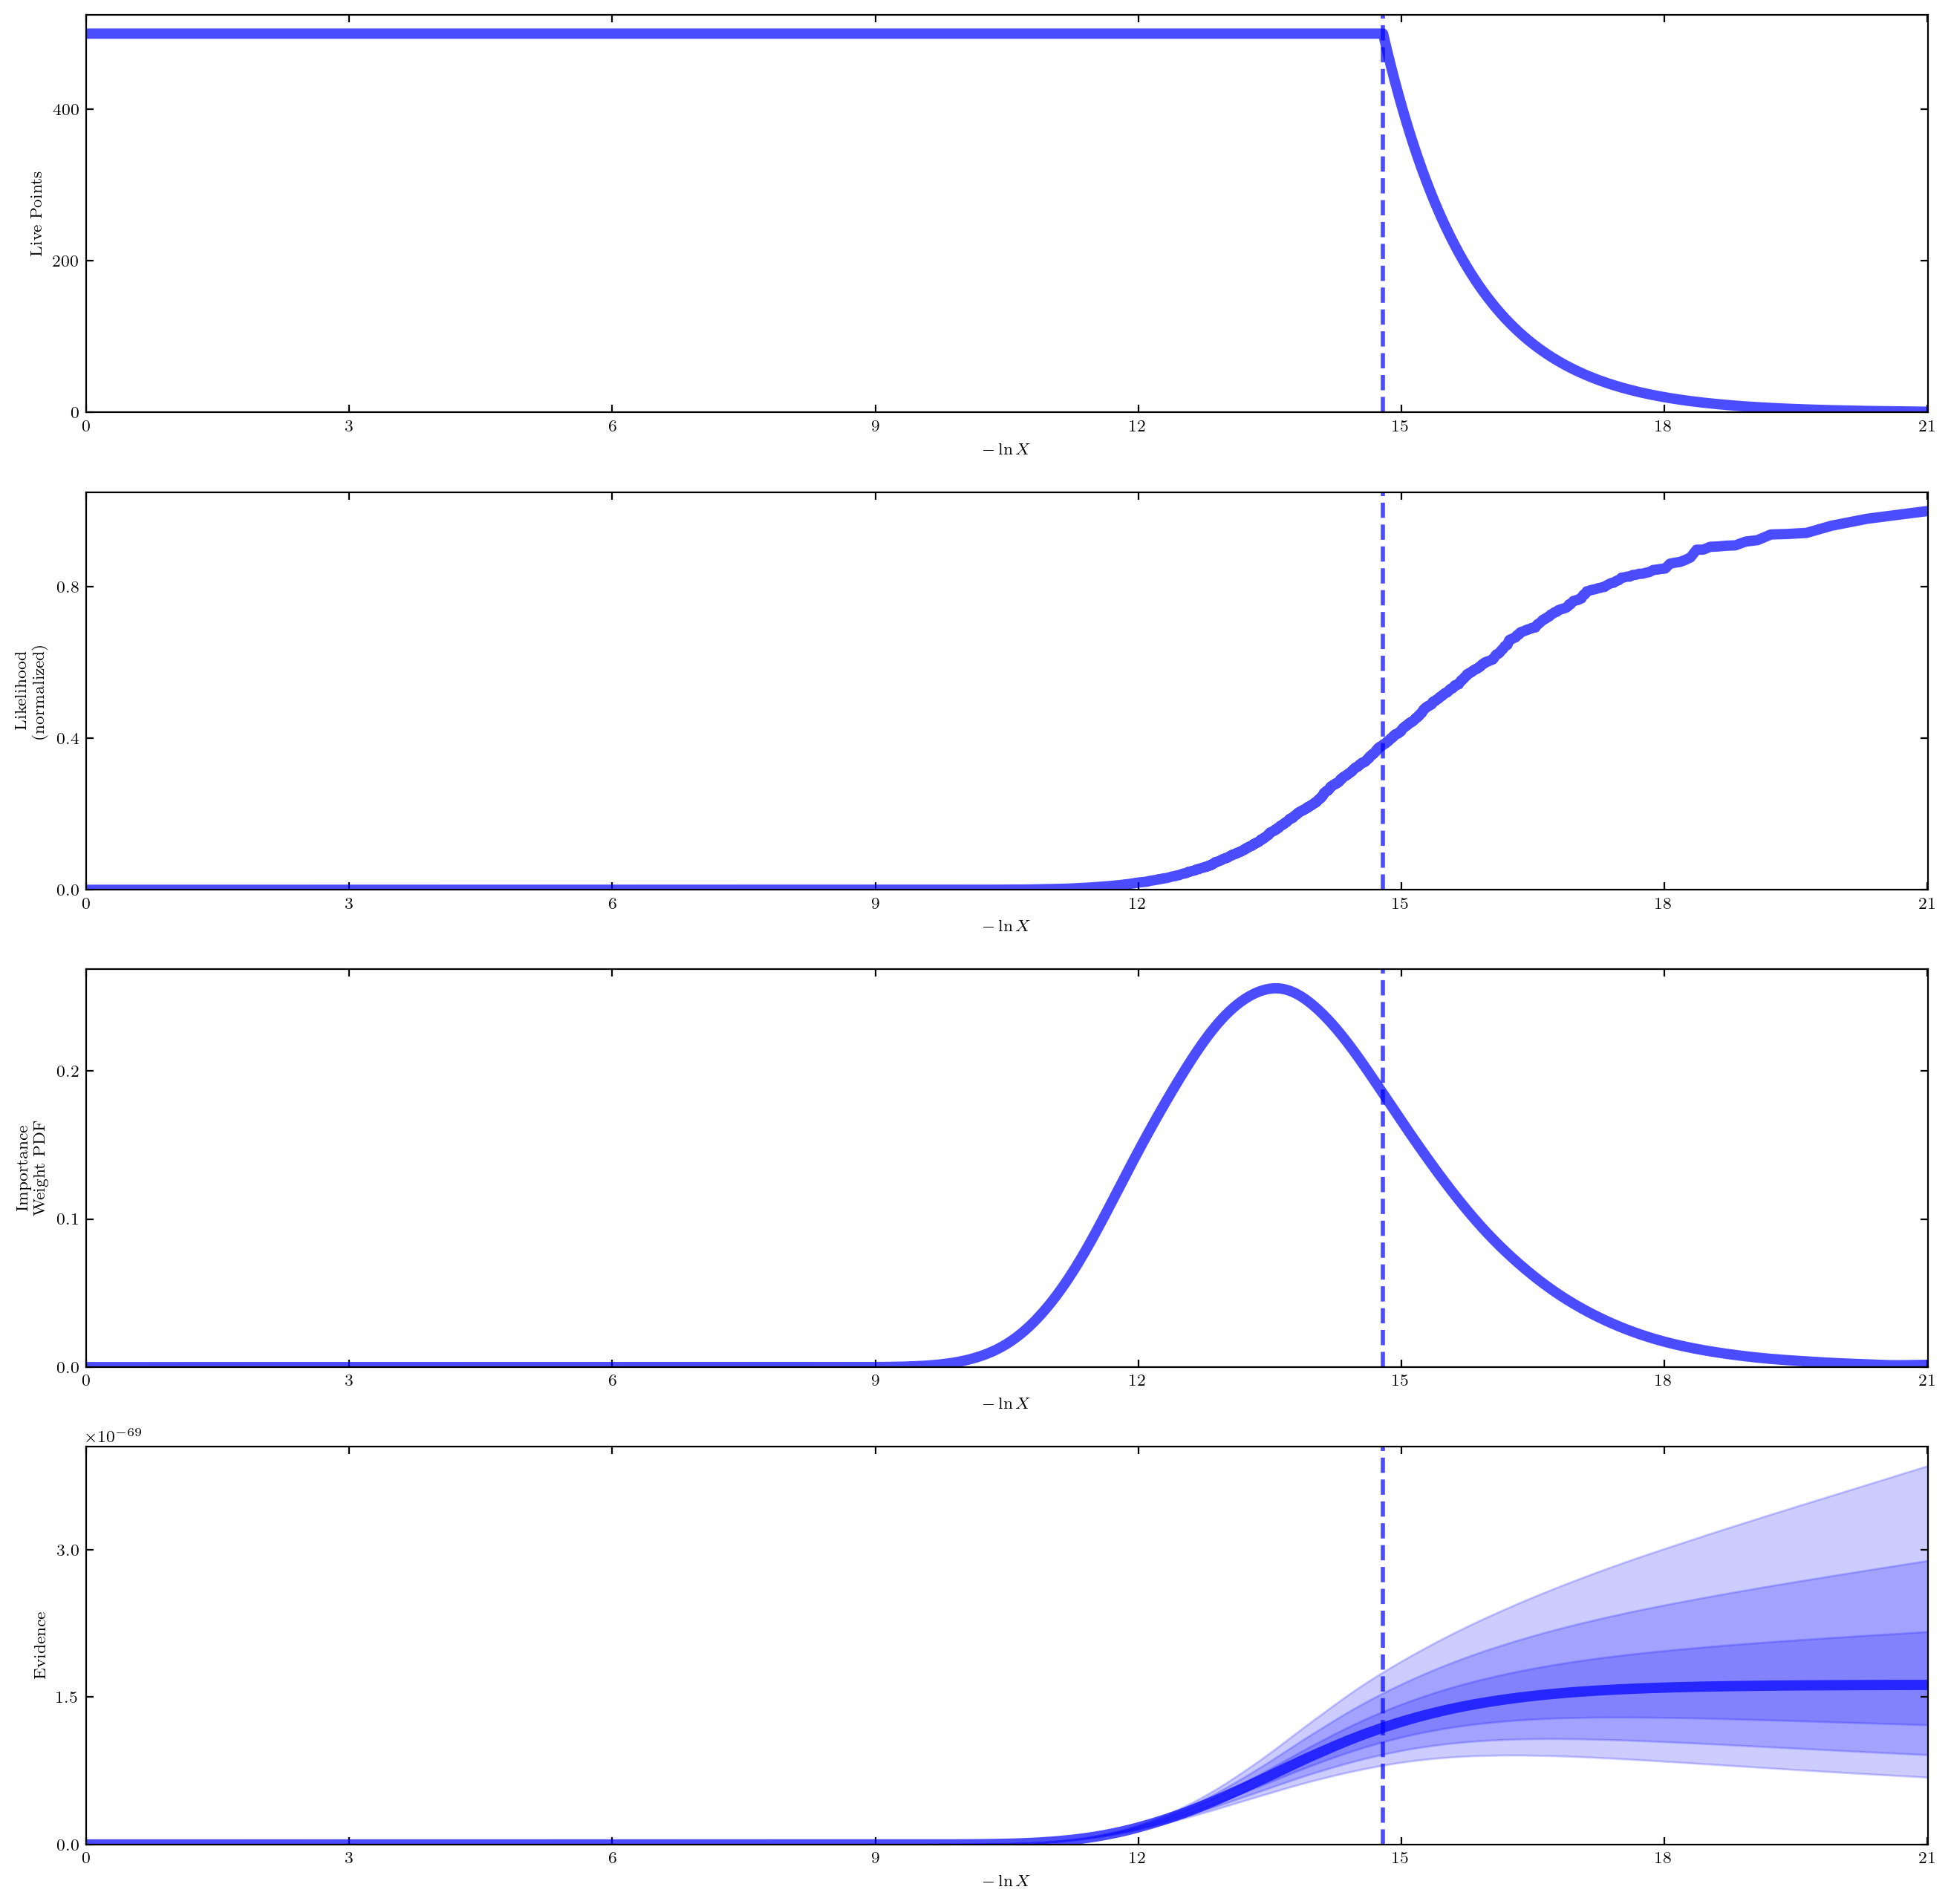

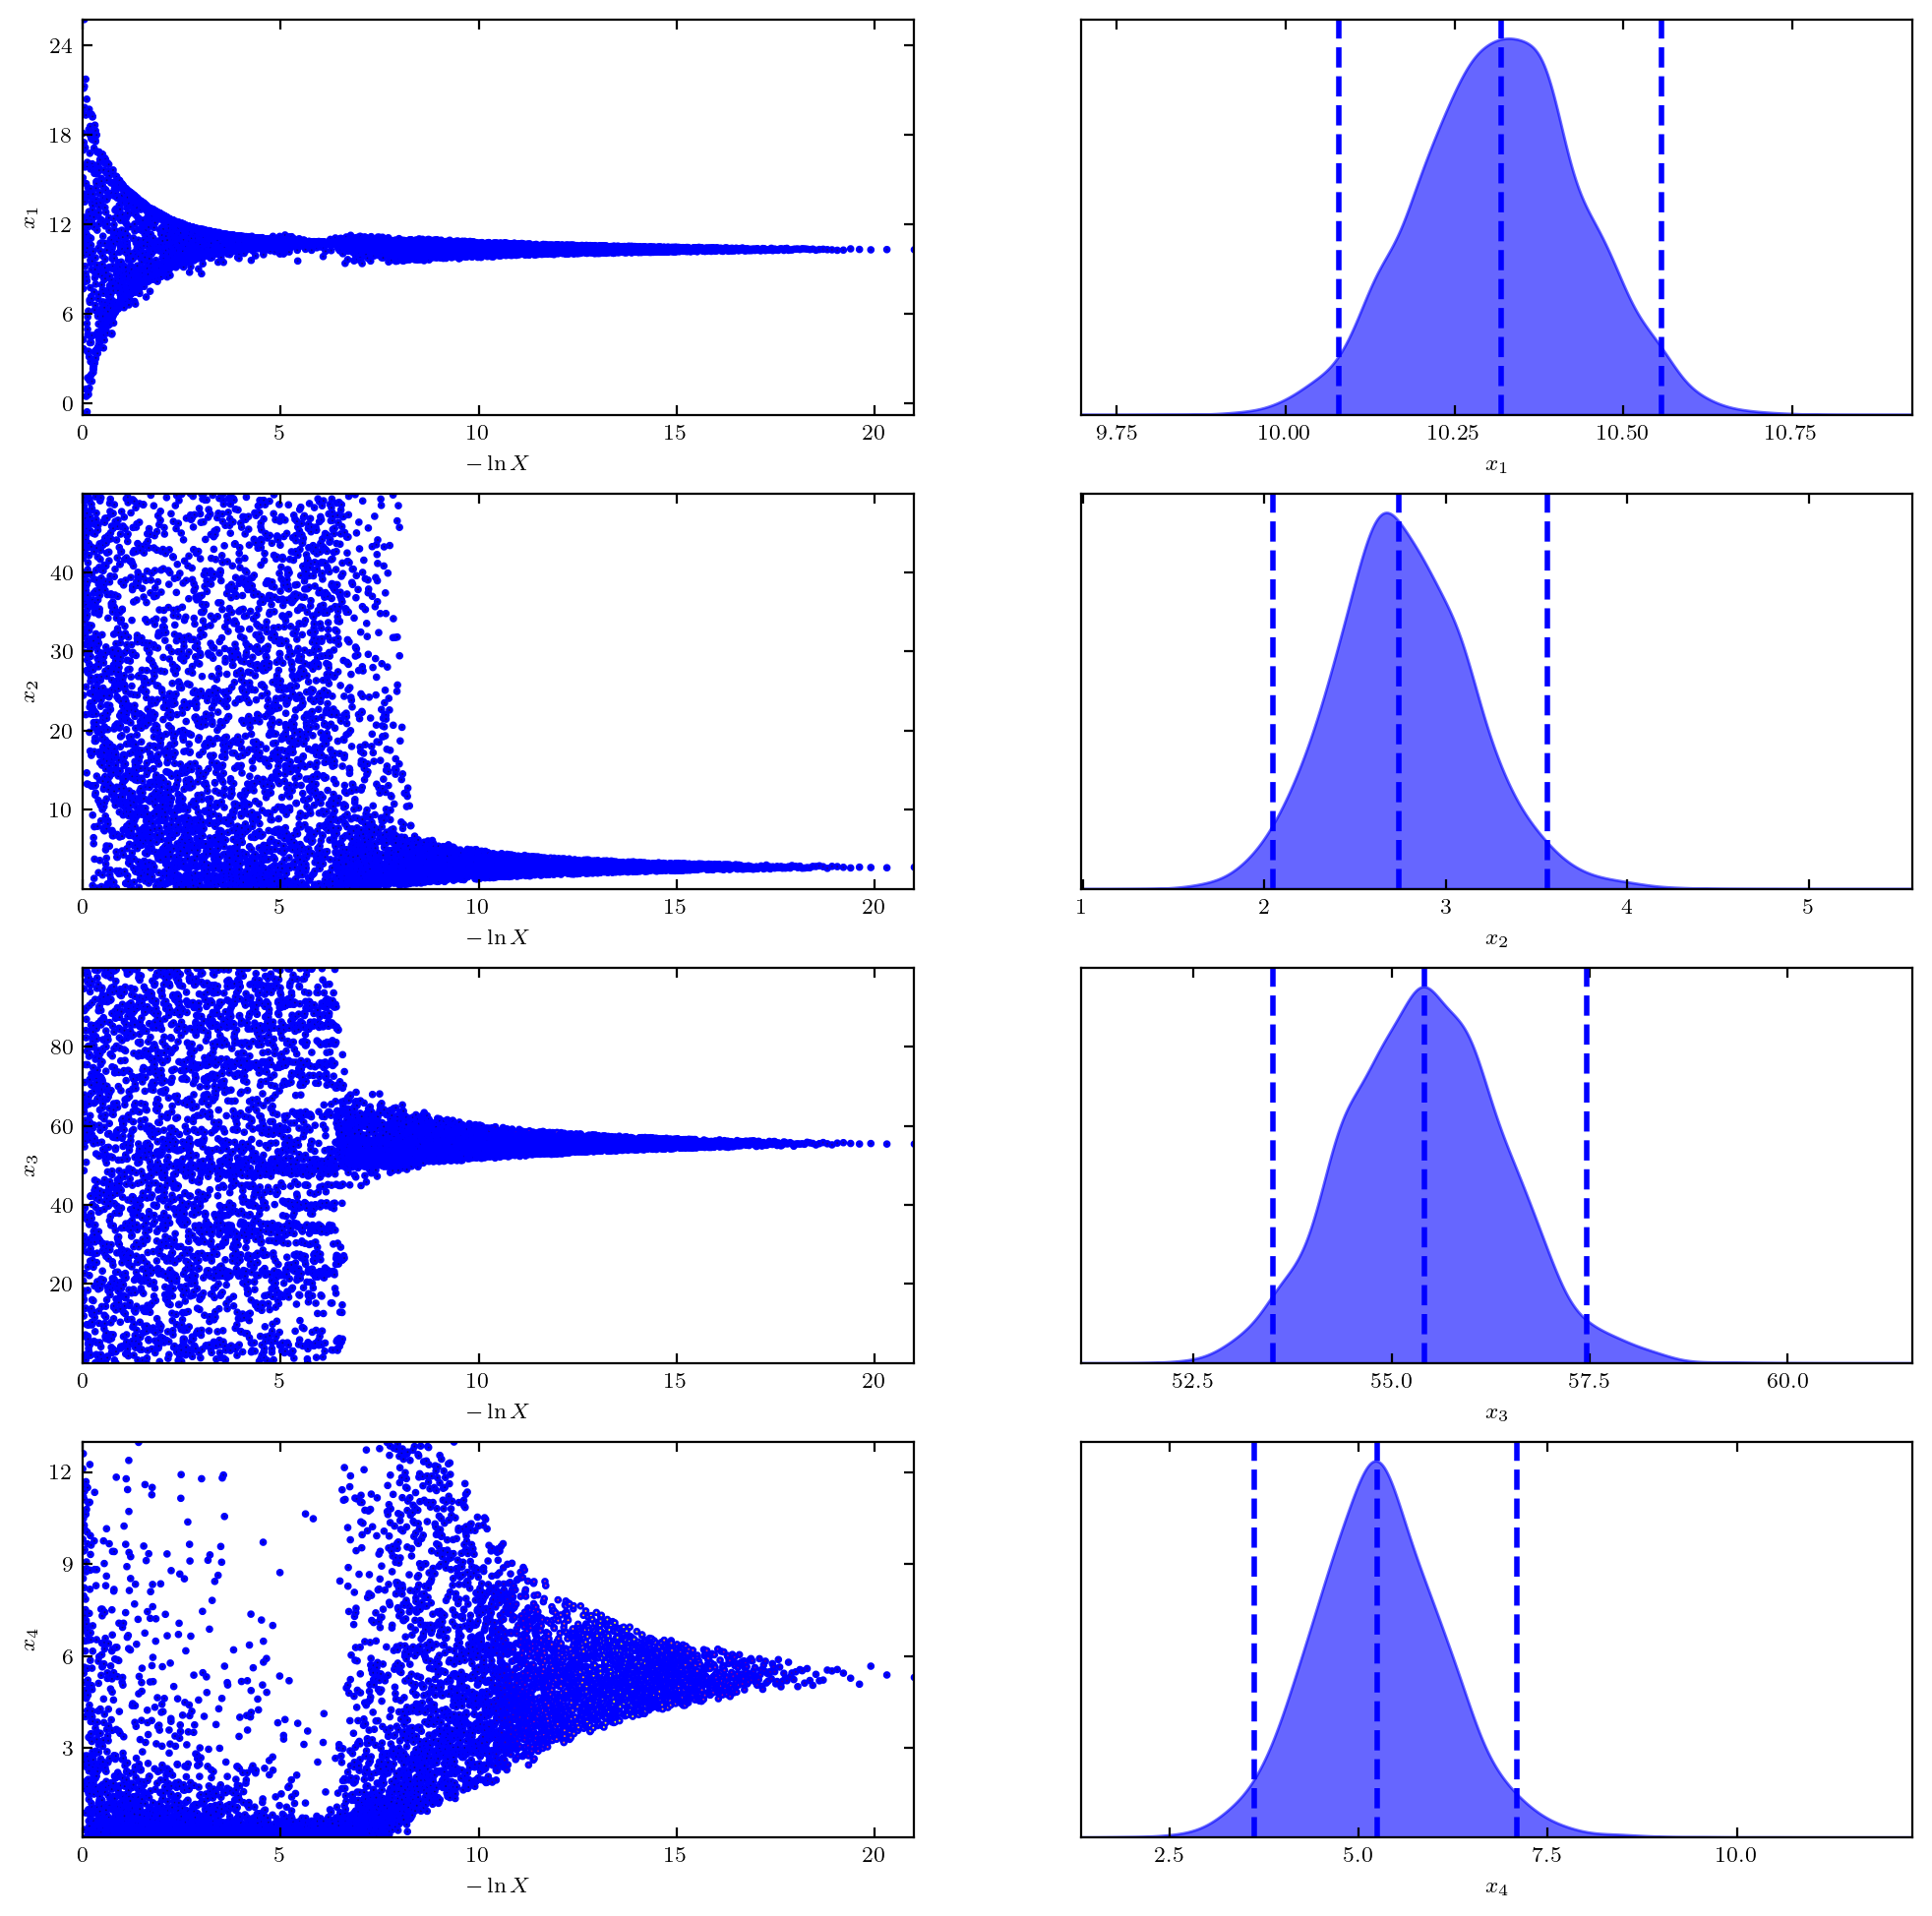

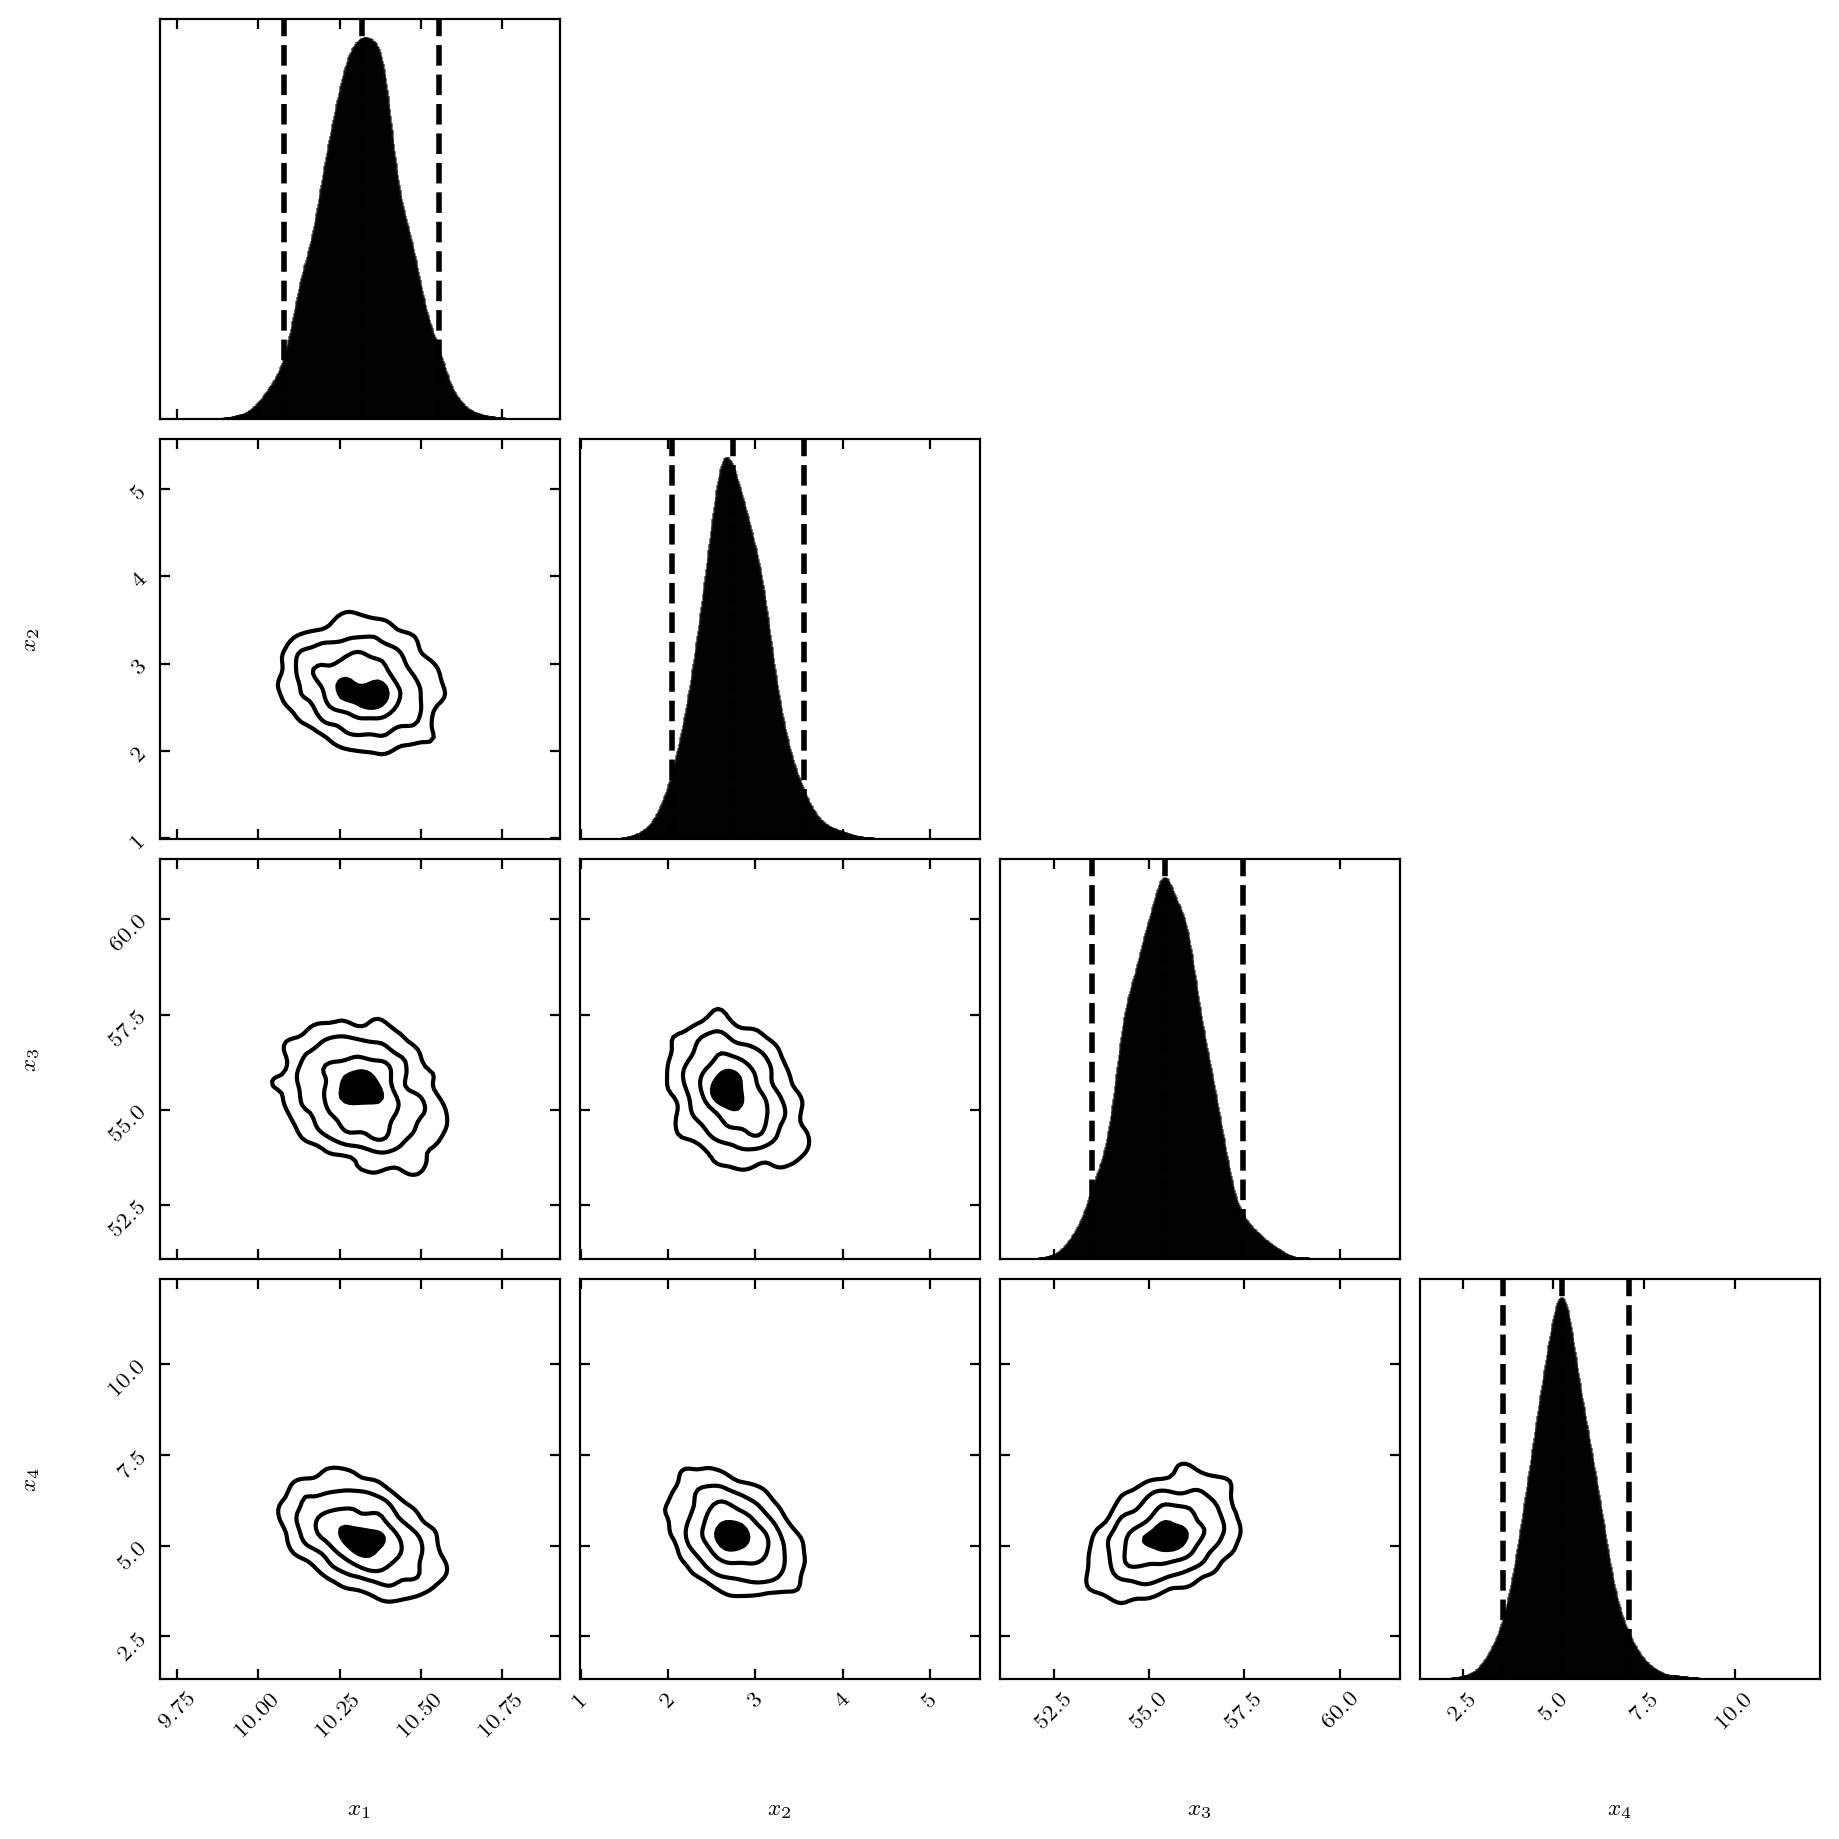

In [69]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults2)
tfig, taxes = dyplot.traceplot(sresults2)
cfig, caxes = dyplot.cornerplot(sresults2)

computation of the bayes factor

In [72]:
samples = sresults.samples 
evidence1=sresults.logz[-1]

samples2=sresults2.samples
evidence2=sresults2.logz[-1]

print("evidence first model:", np.exp(evidence1))
print("evidence second model:", np.exp(evidence2))
print("odd ratio:", np.exp(evidence1)/np.exp(evidence2))

evidence first model: 2.971671593451517e-68
evidence second model: 1.6240811663799637e-69
odd ratio: 18.297555904027252


the "burst model" is the one that describes the data better